In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error')

In [3]:
import logging
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import model_transformer
import anomaly_detection
from utils import SignalDataset
from interface import train

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

In [4]:
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

In [5]:
def known_anomalies(anomalies_list):
    found = list()
    for i in range(len(anomalies_list)):
        if anomalies_list[i] == 1:
            found.append(i)
    return found

In [6]:
def plot(dfs, anomalies=[]):   
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    anomalies_data = []
    if 'anomaly' in df.columns:
        anomalies_data = known_anomalies(df['anomaly'])

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['signal'])
    
    for a_f in anomalies_data:
        plt.axvline(time[a_f], color='r', alpha=0.02)

    plt.title('Dataset', size=34)
    plt.ylabel('value', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])
    
    plt.show()

In [7]:
#plot signal shape
temperature_data = pd.read_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/machine_temperature_system_failure.csv')
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
temperature_data['timestamp'] = temperature_data['timestamp'].apply(lambda x: (x-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
temperature_data = temperature_data.rename(columns={"value": "signal"})
temperature_data['anomaly'] = 0
min_max_scaler = MinMaxScaler()
temperature_data[['signal']] = min_max_scaler.fit_transform(temperature_data[["signal"]])

In [8]:
temperature_data_train = temperature_data[:5000]
print(temperature_data_train.head())
print(temperature_data_train.info())
temperature_data_train.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train.csv', index=False)

    timestamp    signal  anomaly
0  1386018900  0.675424        0
1  1386019200  0.684525        0
2  1386019500  0.695691        0
3  1386019800  0.714638        0
4  1386020100  0.725812        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5000 non-null   int64  
 1   signal     5000 non-null   float64
 2   anomaly    5000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 117.3 KB
None


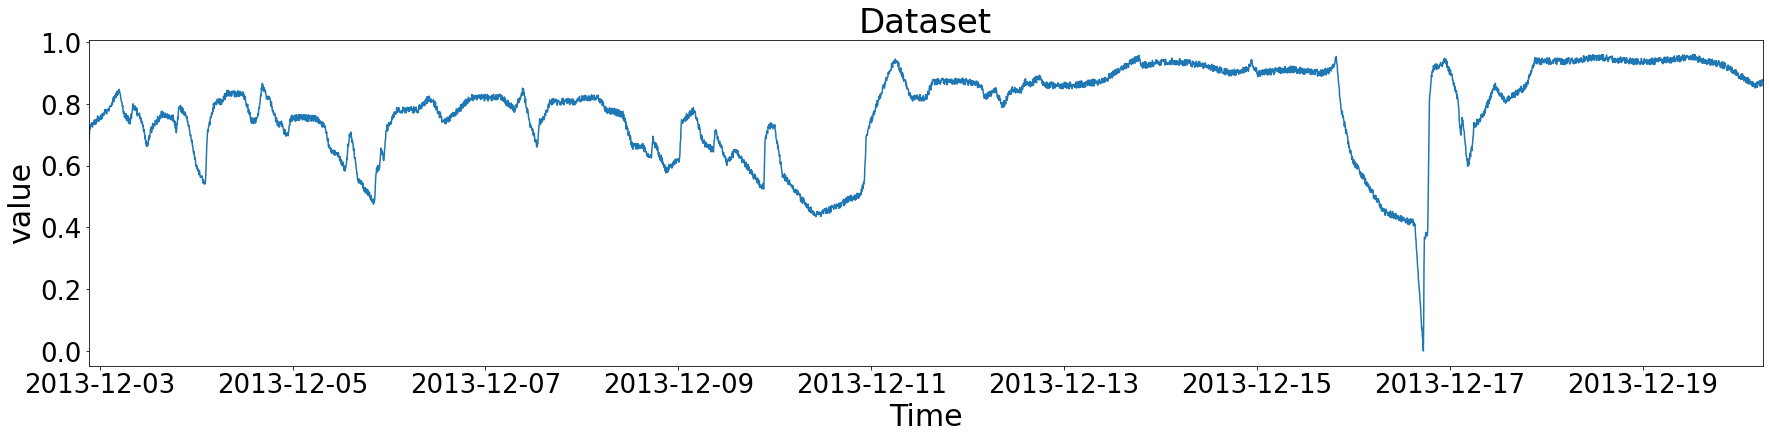

In [9]:
plot(temperature_data_train)

In [10]:
temperature_data_test = temperature_data[5000:7000]
print(temperature_data_test.head())
print(temperature_data_test.info())
temperature_data_test.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test.csv', index=False)

       timestamp    signal  anomaly
5000  1387518900  0.872812        0
5001  1387519200  0.878082        0
5002  1387519500  0.879614        0
5003  1387519800  0.870780        0
5004  1387520100  0.880160        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 5000 to 6999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2000 non-null   int64  
 1   signal     2000 non-null   float64
 2   anomaly    2000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 47.0 KB
None


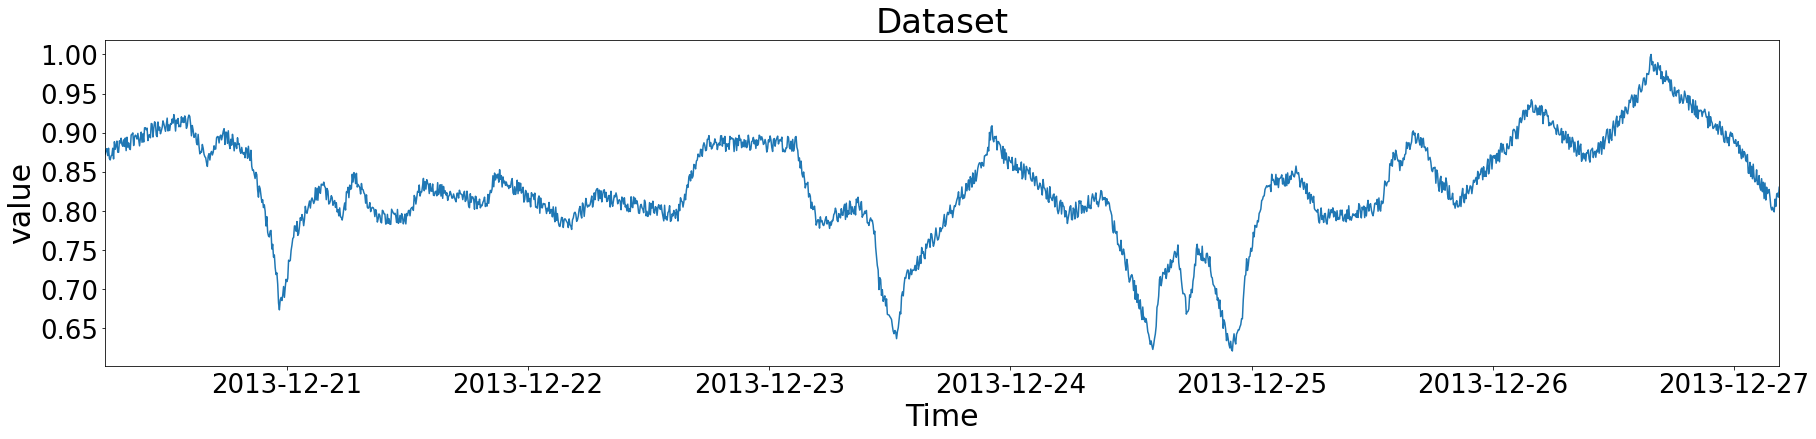

In [11]:
if isinstance(temperature_data_test, pd.DataFrame):
    dfs = [temperature_data_test]
        
df = dfs[0]
time = convert_date(df['timestamp'])


fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

for df in dfs:
    plt.plot(time, df['signal'])


plt.title('Dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.xlim([time[0], time[-1]])
    
plt.show()

In [12]:
train_dataset = SignalDataset(path=f'/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train.csv')
test_dataset = SignalDataset(path=f'/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test.csv')

In [13]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    # The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through
    # encoding x)
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  # Wasserstein Loss

    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_)  # Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    # Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    # Critic has to maximize Cx(Valid X) - Cx(Fake X).
    # Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss
    loss.backward()
    optim_cx.step()

    return loss

In [14]:
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)  # Wasserstein Loss

    wl = critic_score_fake_z - critic_score_valid_z

    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_)  # Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    loss = wl + gp_loss
    loss.backward()
    optim_cz.step()

    return loss

In [15]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc

In [16]:
def decoder_iteration(sample):
    optim_dec.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z
    loss_dec.backward(retain_graph=True)
    optim_dec.step()

    return loss_dec

In [17]:
def train(n_epochs=100):
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    for epoch in range(n_epochs):
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, sample in tqdm(enumerate(train_loader)):
                loss = critic_x_iteration(sample)
                cx_loss.append(loss)

                loss = critic_z_iteration(sample)
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        encoder_loss = list()
        decoder_loss = list()

        for batch, sample in tqdm(enumerate(train_loader)):
            enc_loss = encoder_iteration(sample)
            dec_loss = decoder_iteration(sample)
            encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))
        print("epoch", epoch)
        print('critic x loss {:.3f} critic z loss {:.3f} encoder loss {:.3f} decoder loss {:.3f}\n'.format(
            cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))

In [18]:
def evaluate(test_loader):

    reconstructed_unroll = []

    for batch, sample in tqdm(enumerate(test_loader)):
        reconstructed_signal = decoder(encoder(sample['signal']))
        reconstructed_signal = torch.squeeze(reconstructed_signal)
        median_values, median_indices = torch.median(reconstructed_signal, 1)
        median_values_list = median_values.tolist()
        reconstructed_unroll.extend(median_values_list)
    return np.asarray(reconstructed_unroll)

In [20]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

lr = 1e-6

signal_shape = 100
latent_space_dim = 20

encoder = model_transformer.Encoder(signal_shape)
decoder = model_transformer.Decoder(signal_shape)
critic_x = model_transformer.CriticX(signal_shape)
critic_z = model_transformer.CriticZ()

mse_loss = torch.nn.MSELoss()

optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))

train(n_epochs = 250)

76it [00:07,  9.54it/s]
76it [00:07,  9.61it/s]
76it [00:07,  9.56it/s]
76it [00:07,  9.77it/s]
76it [00:07,  9.75it/s]
76it [00:17,  4.46it/s]


epoch 0
critic x loss 0.302 critic z loss 0.485 encoder loss 0.768 decoder loss 0.545



76it [00:07,  9.65it/s]
76it [00:07,  9.85it/s]
76it [00:08,  8.93it/s]
76it [00:07,  9.76it/s]
76it [00:07,  9.57it/s]
76it [00:16,  4.66it/s]


epoch 1
critic x loss 0.242 critic z loss 0.534 encoder loss 0.721 decoder loss 0.411



76it [00:07,  9.90it/s]
76it [00:07,  9.75it/s]
76it [00:07,  9.67it/s]
76it [00:07,  9.73it/s]
76it [00:07,  9.64it/s]
76it [00:16,  4.64it/s]


epoch 2
critic x loss 0.185 critic z loss 0.547 encoder loss 0.709 decoder loss 0.358



76it [00:07,  9.70it/s]
76it [00:08,  9.07it/s]
76it [00:07,  9.76it/s]
76it [00:07, 10.18it/s]
76it [00:08,  9.42it/s]
76it [00:16,  4.63it/s]


epoch 3
critic x loss 0.129 critic z loss 0.531 encoder loss 0.722 decoder loss 0.330



76it [00:08,  8.46it/s]
76it [00:08,  9.35it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.16it/s]
76it [00:08,  8.67it/s]
76it [00:17,  4.36it/s]


epoch 4
critic x loss 0.075 critic z loss 0.502 encoder loss 0.739 decoder loss 0.328



76it [00:08,  9.36it/s]
76it [00:08,  9.34it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.04it/s]
76it [00:16,  4.52it/s]


epoch 5
critic x loss 0.024 critic z loss 0.464 encoder loss 0.758 decoder loss 0.338



76it [00:08,  8.93it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.18it/s]
76it [00:16,  4.56it/s]


epoch 6
critic x loss -0.028 critic z loss 0.430 encoder loss 0.788 decoder loss 0.350



76it [00:07,  9.50it/s]
76it [00:08,  9.45it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.25it/s]
76it [00:16,  4.56it/s]


epoch 7
critic x loss -0.079 critic z loss 0.393 encoder loss 0.818 decoder loss 0.366



76it [00:08,  9.06it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.18it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.29it/s]
76it [00:16,  4.53it/s]


epoch 8
critic x loss -0.133 critic z loss 0.358 encoder loss 0.852 decoder loss 0.379



76it [00:08,  9.21it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.22it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.27it/s]
76it [00:16,  4.48it/s]


epoch 9
critic x loss -0.186 critic z loss 0.328 encoder loss 0.890 decoder loss 0.392



76it [00:08,  8.90it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.40it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.21it/s]
76it [00:16,  4.48it/s]


epoch 10
critic x loss -0.236 critic z loss 0.298 encoder loss 0.926 decoder loss 0.412



76it [00:08,  9.13it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.53it/s]


epoch 11
critic x loss -0.287 critic z loss 0.272 encoder loss 0.962 decoder loss 0.408



76it [00:08,  9.09it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.22it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.29it/s]
76it [00:16,  4.49it/s]


epoch 12
critic x loss -0.337 critic z loss 0.251 encoder loss 1.006 decoder loss 0.429



76it [00:08,  9.06it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.25it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.10it/s]
76it [00:16,  4.54it/s]


epoch 13
critic x loss -0.391 critic z loss 0.225 encoder loss 1.044 decoder loss 0.436



76it [00:08,  9.17it/s]
76it [00:08,  9.25it/s]
76it [00:08,  8.86it/s]
76it [00:09,  7.84it/s]
76it [00:08,  9.25it/s]
76it [00:17,  4.35it/s]


epoch 14
critic x loss -0.439 critic z loss 0.204 encoder loss 1.086 decoder loss 0.447



76it [00:08,  9.31it/s]
76it [00:08,  9.26it/s]
76it [00:08,  9.16it/s]
76it [00:09,  7.66it/s]
76it [00:08,  9.30it/s]
76it [00:17,  4.43it/s]


epoch 15
critic x loss -0.491 critic z loss 0.184 encoder loss 1.129 decoder loss 0.464



76it [00:08,  9.38it/s]
76it [00:08,  9.27it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.07it/s]
76it [00:17,  4.46it/s]


epoch 16
critic x loss -0.541 critic z loss 0.165 encoder loss 1.171 decoder loss 0.474



76it [00:08,  9.08it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.03it/s]
76it [00:16,  4.53it/s]


epoch 17
critic x loss -0.591 critic z loss 0.149 encoder loss 1.214 decoder loss 0.486



76it [00:08,  9.14it/s]
76it [00:08,  8.94it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.28it/s]
76it [00:16,  4.53it/s]


epoch 18
critic x loss -0.639 critic z loss 0.130 encoder loss 1.260 decoder loss 0.490



76it [00:08,  9.30it/s]
76it [00:08,  9.30it/s]
76it [00:08,  9.36it/s]
76it [00:08,  9.28it/s]
76it [00:08,  9.15it/s]
76it [00:16,  4.52it/s]


epoch 19
critic x loss -0.690 critic z loss 0.117 encoder loss 1.299 decoder loss 0.504



76it [00:08,  9.23it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.27it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.38it/s]
76it [00:16,  4.50it/s]


epoch 20
critic x loss -0.740 critic z loss 0.102 encoder loss 1.344 decoder loss 0.511



76it [00:08,  9.11it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.30it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.32it/s]
76it [00:16,  4.51it/s]


epoch 21
critic x loss -0.787 critic z loss 0.089 encoder loss 1.391 decoder loss 0.520



76it [00:08,  9.27it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.09it/s]
76it [00:16,  4.51it/s]


epoch 22
critic x loss -0.833 critic z loss 0.075 encoder loss 1.432 decoder loss 0.527



76it [00:08,  9.26it/s]
76it [00:08,  9.28it/s]
76it [00:08,  9.30it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.40it/s]
76it [00:16,  4.51it/s]


epoch 23
critic x loss -0.881 critic z loss 0.063 encoder loss 1.478 decoder loss 0.533



76it [00:08,  9.07it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.35it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.52it/s]


epoch 24
critic x loss -0.930 critic z loss 0.051 encoder loss 1.521 decoder loss 0.545



76it [00:08,  9.22it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.53it/s]


epoch 25
critic x loss -0.976 critic z loss 0.038 encoder loss 1.567 decoder loss 0.549



76it [00:08,  9.15it/s]
76it [00:08,  9.08it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.87it/s]
76it [00:17,  4.40it/s]


epoch 26
critic x loss -1.025 critic z loss 0.029 encoder loss 1.604 decoder loss 0.557



76it [00:08,  9.03it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.07it/s]
76it [00:16,  4.51it/s]


epoch 27
critic x loss -1.070 critic z loss 0.020 encoder loss 1.654 decoder loss 0.566



76it [00:08,  9.03it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.16it/s]
76it [00:16,  4.51it/s]


epoch 28
critic x loss -1.116 critic z loss 0.010 encoder loss 1.693 decoder loss 0.573



76it [00:08,  9.18it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.28it/s]
76it [00:08,  9.20it/s]
76it [00:16,  4.49it/s]


epoch 29
critic x loss -1.167 critic z loss 0.001 encoder loss 1.746 decoder loss 0.576



76it [00:08,  9.12it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.21it/s]
76it [00:16,  4.51it/s]


epoch 30
critic x loss -1.211 critic z loss -0.008 encoder loss 1.781 decoder loss 0.582



76it [00:08,  9.09it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.03it/s]
76it [00:17,  4.44it/s]


epoch 31
critic x loss -1.254 critic z loss -0.018 encoder loss 1.835 decoder loss 0.587



76it [00:08,  9.13it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.16it/s]
76it [00:16,  4.53it/s]


epoch 32
critic x loss -1.303 critic z loss -0.029 encoder loss 1.870 decoder loss 0.593



76it [00:08,  9.24it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.12it/s]
76it [00:16,  4.50it/s]


epoch 33
critic x loss -1.349 critic z loss -0.037 encoder loss 1.919 decoder loss 0.606



76it [00:08,  9.04it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.07it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.49it/s]


epoch 34
critic x loss -1.394 critic z loss -0.044 encoder loss 1.962 decoder loss 0.614



76it [00:08,  9.00it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.13it/s]
76it [00:16,  4.52it/s]


epoch 35
critic x loss -1.439 critic z loss -0.052 encoder loss 1.999 decoder loss 0.613



76it [00:08,  9.31it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.05it/s]
76it [00:17,  4.46it/s]


epoch 36
critic x loss -1.485 critic z loss -0.062 encoder loss 2.052 decoder loss 0.621



76it [00:08,  8.97it/s]
76it [00:08,  8.84it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.18it/s]
76it [00:08,  8.96it/s]
76it [00:17,  4.43it/s]


epoch 37
critic x loss -1.528 critic z loss -0.070 encoder loss 2.095 decoder loss 0.628



76it [00:08,  9.02it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.91it/s]
76it [00:17,  4.43it/s]


epoch 38
critic x loss -1.572 critic z loss -0.078 encoder loss 2.137 decoder loss 0.638



76it [00:08,  9.03it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.24it/s]
76it [00:08,  9.11it/s]
76it [00:16,  4.48it/s]


epoch 39
critic x loss -1.623 critic z loss -0.087 encoder loss 2.188 decoder loss 0.640



76it [00:08,  9.11it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.25it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.53it/s]


epoch 40
critic x loss -1.665 critic z loss -0.093 encoder loss 2.233 decoder loss 0.638



76it [00:08,  9.18it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.31it/s]
76it [00:08,  9.14it/s]
76it [00:16,  4.50it/s]


epoch 41
critic x loss -1.709 critic z loss -0.101 encoder loss 2.262 decoder loss 0.642



76it [00:08,  9.19it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.29it/s]
76it [00:08,  8.90it/s]
76it [00:16,  4.48it/s]


epoch 42
critic x loss -1.749 critic z loss -0.107 encoder loss 2.323 decoder loss 0.652



76it [00:08,  9.30it/s]
76it [00:08,  9.26it/s]
76it [00:08,  9.40it/s]
76it [00:08,  9.24it/s]
76it [00:08,  9.09it/s]
76it [00:16,  4.51it/s]


epoch 43
critic x loss -1.797 critic z loss -0.114 encoder loss 2.351 decoder loss 0.662



76it [00:08,  9.08it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.31it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.31it/s]
76it [00:16,  4.52it/s]


epoch 44
critic x loss -1.838 critic z loss -0.118 encoder loss 2.396 decoder loss 0.666



76it [00:08,  9.33it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.15it/s]
76it [00:16,  4.53it/s]


epoch 45
critic x loss -1.883 critic z loss -0.128 encoder loss 2.441 decoder loss 0.667



76it [00:08,  9.40it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.25it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.21it/s]
76it [00:16,  4.50it/s]


epoch 46
critic x loss -1.930 critic z loss -0.139 encoder loss 2.486 decoder loss 0.674



76it [00:08,  9.33it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.38it/s]
76it [00:16,  4.55it/s]


epoch 47
critic x loss -1.971 critic z loss -0.145 encoder loss 2.532 decoder loss 0.678



76it [00:08,  9.06it/s]
76it [00:08,  8.87it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.27it/s]
76it [00:08,  9.25it/s]
76it [00:16,  4.51it/s]


epoch 48
critic x loss -2.014 critic z loss -0.150 encoder loss 2.572 decoder loss 0.687



76it [00:08,  9.20it/s]
76it [00:08,  9.26it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.09it/s]
76it [00:16,  4.49it/s]


epoch 49
critic x loss -2.063 critic z loss -0.157 encoder loss 2.613 decoder loss 0.687



76it [00:08,  9.08it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.31it/s]
76it [00:16,  4.51it/s]


epoch 50
critic x loss -2.105 critic z loss -0.161 encoder loss 2.654 decoder loss 0.691



76it [00:08,  9.08it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.33it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.53it/s]


epoch 51
critic x loss -2.144 critic z loss -0.170 encoder loss 2.697 decoder loss 0.704



76it [00:08,  9.08it/s]
76it [00:08,  9.05it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.15it/s]
76it [00:17,  4.47it/s]


epoch 52
critic x loss -2.193 critic z loss -0.177 encoder loss 2.731 decoder loss 0.700



76it [00:08,  9.04it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.11it/s]
76it [00:08,  8.96it/s]
76it [00:17,  4.45it/s]


epoch 53
critic x loss -2.230 critic z loss -0.183 encoder loss 2.783 decoder loss 0.710



76it [00:08,  9.13it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.49it/s]


epoch 54
critic x loss -2.270 critic z loss -0.187 encoder loss 2.830 decoder loss 0.711



76it [00:08,  8.95it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.25it/s]
76it [00:16,  4.50it/s]


epoch 55
critic x loss -2.316 critic z loss -0.193 encoder loss 2.853 decoder loss 0.712



76it [00:08,  9.05it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.09it/s]
76it [00:16,  4.52it/s]


epoch 56
critic x loss -2.357 critic z loss -0.198 encoder loss 2.909 decoder loss 0.723



76it [00:08,  9.01it/s]
76it [00:08,  9.07it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.03it/s]
76it [00:17,  4.46it/s]


epoch 57
critic x loss -2.399 critic z loss -0.207 encoder loss 2.951 decoder loss 0.726



76it [00:08,  8.85it/s]
76it [00:08,  9.10it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.91it/s]
76it [00:17,  4.46it/s]


epoch 58
critic x loss -2.440 critic z loss -0.212 encoder loss 2.981 decoder loss 0.729



76it [00:08,  8.88it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.94it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.12it/s]
76it [00:17,  4.42it/s]


epoch 59
critic x loss -2.486 critic z loss -0.219 encoder loss 3.020 decoder loss 0.734



76it [00:08,  8.95it/s]
76it [00:08,  9.07it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.86it/s]
76it [00:17,  4.43it/s]


epoch 60
critic x loss -2.529 critic z loss -0.222 encoder loss 3.058 decoder loss 0.741



76it [00:08,  8.96it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.08it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.47it/s]


epoch 61
critic x loss -2.570 critic z loss -0.228 encoder loss 3.102 decoder loss 0.745



76it [00:08,  9.11it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.01it/s]
76it [00:17,  4.46it/s]


epoch 62
critic x loss -2.607 critic z loss -0.235 encoder loss 3.144 decoder loss 0.744



76it [00:08,  9.06it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.22it/s]
76it [00:08,  8.88it/s]
76it [00:17,  4.45it/s]


epoch 63
critic x loss -2.647 critic z loss -0.241 encoder loss 3.189 decoder loss 0.748



76it [00:08,  9.17it/s]
76it [00:08,  9.12it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.98it/s]
76it [00:17,  4.44it/s]


epoch 64
critic x loss -2.695 critic z loss -0.245 encoder loss 3.245 decoder loss 0.755



76it [00:08,  9.03it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.05it/s]
76it [00:16,  4.48it/s]


epoch 65
critic x loss -2.738 critic z loss -0.250 encoder loss 3.285 decoder loss 0.761



76it [00:08,  9.04it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.13it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.48it/s]


epoch 66
critic x loss -2.773 critic z loss -0.258 encoder loss 3.332 decoder loss 0.758



76it [00:08,  9.02it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.98it/s]
76it [00:17,  4.46it/s]


epoch 67
critic x loss -2.817 critic z loss -0.263 encoder loss 3.366 decoder loss 0.770



76it [00:08,  9.08it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.48it/s]


epoch 68
critic x loss -2.853 critic z loss -0.268 encoder loss 3.395 decoder loss 0.769



76it [00:08,  9.08it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.04it/s]
76it [00:17,  4.43it/s]


epoch 69
critic x loss -2.897 critic z loss -0.273 encoder loss 3.429 decoder loss 0.772



76it [00:08,  9.10it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.13it/s]
76it [00:16,  4.51it/s]


epoch 70
critic x loss -2.940 critic z loss -0.275 encoder loss 3.491 decoder loss 0.776



76it [00:08,  9.21it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.51it/s]


epoch 71
critic x loss -2.977 critic z loss -0.285 encoder loss 3.523 decoder loss 0.782



76it [00:08,  9.05it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.21it/s]
76it [00:08,  8.94it/s]
76it [00:08,  9.12it/s]
76it [00:17,  4.45it/s]


epoch 72
critic x loss -3.021 critic z loss -0.290 encoder loss 3.573 decoder loss 0.784



76it [00:08,  9.14it/s]
76it [00:08,  9.24it/s]
76it [00:08,  9.33it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.19it/s]
76it [00:16,  4.52it/s]


epoch 73
critic x loss -3.061 critic z loss -0.294 encoder loss 3.593 decoder loss 0.786



76it [00:08,  9.14it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.09it/s]
76it [00:16,  4.52it/s]


epoch 74
critic x loss -3.102 critic z loss -0.296 encoder loss 3.636 decoder loss 0.790



76it [00:08,  9.11it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.17it/s]
76it [00:16,  4.52it/s]


epoch 75
critic x loss -3.145 critic z loss -0.304 encoder loss 3.679 decoder loss 0.796



76it [00:08,  9.06it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.21it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.07it/s]
76it [00:16,  4.53it/s]


epoch 76
critic x loss -3.179 critic z loss -0.306 encoder loss 3.723 decoder loss 0.798



76it [00:08,  9.09it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.11it/s]
76it [00:08,  8.93it/s]
76it [00:17,  4.44it/s]


epoch 77
critic x loss -3.219 critic z loss -0.315 encoder loss 3.778 decoder loss 0.804



76it [00:08,  9.05it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.51it/s]


epoch 78
critic x loss -3.267 critic z loss -0.315 encoder loss 3.795 decoder loss 0.804



76it [00:08,  9.00it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.48it/s]


epoch 79
critic x loss -3.304 critic z loss -0.323 encoder loss 3.837 decoder loss 0.808



76it [00:08,  9.12it/s]
76it [00:08,  9.17it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.48it/s]


epoch 80
critic x loss -3.339 critic z loss -0.327 encoder loss 3.880 decoder loss 0.813



76it [00:08,  9.04it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.27it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.08it/s]
76it [00:16,  4.48it/s]


epoch 81
critic x loss -3.386 critic z loss -0.330 encoder loss 3.911 decoder loss 0.815



76it [00:08,  9.21it/s]
76it [00:08,  9.20it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.00it/s]
76it [00:17,  4.43it/s]


epoch 82
critic x loss -3.419 critic z loss -0.335 encoder loss 3.975 decoder loss 0.820



76it [00:08,  8.82it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.85it/s]
76it [00:17,  4.45it/s]


epoch 83
critic x loss -3.460 critic z loss -0.344 encoder loss 3.991 decoder loss 0.829



76it [00:08,  8.96it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.01it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.49it/s]


epoch 84
critic x loss -3.498 critic z loss -0.347 encoder loss 4.045 decoder loss 0.830



76it [00:08,  9.02it/s]
76it [00:08,  8.87it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.00it/s]
76it [00:17,  4.40it/s]


epoch 85
critic x loss -3.539 critic z loss -0.351 encoder loss 4.062 decoder loss 0.827



76it [00:08,  8.92it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.06it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.50it/s]


epoch 86
critic x loss -3.575 critic z loss -0.357 encoder loss 4.115 decoder loss 0.833



76it [00:08,  8.93it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.86it/s]
76it [00:17,  4.43it/s]


epoch 87
critic x loss -3.617 critic z loss -0.359 encoder loss 4.162 decoder loss 0.838



76it [00:08,  8.95it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.09it/s]
76it [00:17,  4.46it/s]


epoch 88
critic x loss -3.654 critic z loss -0.366 encoder loss 4.193 decoder loss 0.838



76it [00:08,  9.01it/s]
76it [00:08,  9.16it/s]
76it [00:08,  8.91it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.05it/s]
76it [00:17,  4.44it/s]


epoch 89
critic x loss -3.688 critic z loss -0.370 encoder loss 4.233 decoder loss 0.846



76it [00:08,  9.11it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.16it/s]
76it [00:16,  4.48it/s]


epoch 90
critic x loss -3.721 critic z loss -0.379 encoder loss 4.271 decoder loss 0.849



76it [00:08,  9.10it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.03it/s]
76it [00:16,  4.48it/s]


epoch 91
critic x loss -3.767 critic z loss -0.381 encoder loss 4.303 decoder loss 0.851



76it [00:08,  9.03it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.19it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.93it/s]
76it [00:17,  4.46it/s]


epoch 92
critic x loss -3.797 critic z loss -0.387 encoder loss 4.347 decoder loss 0.855



76it [00:08,  9.23it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.24it/s]
76it [00:08,  9.22it/s]
76it [00:08,  9.10it/s]
76it [00:16,  4.52it/s]


epoch 93
critic x loss -3.842 critic z loss -0.388 encoder loss 4.379 decoder loss 0.852



76it [00:08,  9.14it/s]
76it [00:08,  9.06it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.52it/s]


epoch 94
critic x loss -3.879 critic z loss -0.390 encoder loss 4.418 decoder loss 0.861



76it [00:08,  8.99it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.88it/s]
76it [00:08,  9.02it/s]
76it [00:17,  4.41it/s]


epoch 95
critic x loss -3.918 critic z loss -0.394 encoder loss 4.457 decoder loss 0.857



76it [00:08,  9.09it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.12it/s]
76it [00:08,  8.99it/s]
76it [00:17,  4.45it/s]


epoch 96
critic x loss -3.957 critic z loss -0.398 encoder loss 4.472 decoder loss 0.865



76it [00:08,  8.92it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.02it/s]
76it [00:17,  4.46it/s]


epoch 97
critic x loss -3.995 critic z loss -0.404 encoder loss 4.545 decoder loss 0.862



76it [00:08,  8.90it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.25it/s]
76it [00:08,  9.07it/s]
76it [00:17,  4.45it/s]


epoch 98
critic x loss -4.022 critic z loss -0.405 encoder loss 4.559 decoder loss 0.867



76it [00:08,  9.08it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.91it/s]
76it [00:17,  4.47it/s]


epoch 99
critic x loss -4.066 critic z loss -0.410 encoder loss 4.601 decoder loss 0.872



76it [00:08,  8.98it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.49it/s]


epoch 100
critic x loss -4.101 critic z loss -0.417 encoder loss 4.623 decoder loss 0.880



76it [00:08,  9.19it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.08it/s]
76it [00:16,  4.47it/s]


epoch 101
critic x loss -4.132 critic z loss -0.421 encoder loss 4.658 decoder loss 0.878



76it [00:08,  9.01it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.91it/s]
76it [00:08,  9.08it/s]
76it [00:17,  4.44it/s]


epoch 102
critic x loss -4.171 critic z loss -0.422 encoder loss 4.715 decoder loss 0.882



76it [00:08,  8.99it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.95it/s]
76it [00:17,  4.47it/s]


epoch 103
critic x loss -4.201 critic z loss -0.428 encoder loss 4.757 decoder loss 0.887



76it [00:08,  8.92it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.92it/s]
76it [00:17,  4.47it/s]


epoch 104
critic x loss -4.235 critic z loss -0.432 encoder loss 4.787 decoder loss 0.889



76it [00:08,  8.85it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.92it/s]
76it [00:17,  4.44it/s]


epoch 105
critic x loss -4.284 critic z loss -0.435 encoder loss 4.826 decoder loss 0.889



76it [00:08,  8.98it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.31it/s]
76it [00:08,  8.91it/s]
76it [00:17,  4.46it/s]


epoch 106
critic x loss -4.312 critic z loss -0.441 encoder loss 4.843 decoder loss 0.894



76it [00:08,  8.98it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.03it/s]
76it [00:17,  4.45it/s]


epoch 107
critic x loss -4.340 critic z loss -0.448 encoder loss 4.877 decoder loss 0.896



76it [00:08,  8.94it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.10it/s]
76it [00:17,  4.45it/s]


epoch 108
critic x loss -4.385 critic z loss -0.455 encoder loss 4.923 decoder loss 0.899



76it [00:08,  9.07it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.12it/s]
76it [00:08,  8.90it/s]
76it [00:16,  4.48it/s]


epoch 109
critic x loss -4.420 critic z loss -0.457 encoder loss 4.942 decoder loss 0.906



76it [00:08,  9.04it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.99it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.87it/s]
76it [00:16,  4.49it/s]


epoch 110
critic x loss -4.458 critic z loss -0.459 encoder loss 5.005 decoder loss 0.911



76it [00:08,  9.18it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.10it/s]
76it [00:16,  4.51it/s]


epoch 111
critic x loss -4.491 critic z loss -0.464 encoder loss 5.040 decoder loss 0.910



76it [00:08,  9.10it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.95it/s]
76it [00:17,  4.39it/s]


epoch 112
critic x loss -4.532 critic z loss -0.466 encoder loss 5.072 decoder loss 0.911



76it [00:08,  8.93it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.11it/s]
76it [00:16,  4.50it/s]


epoch 113
critic x loss -4.562 critic z loss -0.472 encoder loss 5.098 decoder loss 0.917



76it [00:08,  9.02it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.03it/s]
76it [00:16,  4.51it/s]


epoch 114
critic x loss -4.604 critic z loss -0.476 encoder loss 5.159 decoder loss 0.923



76it [00:08,  9.07it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.06it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.97it/s]
76it [00:17,  4.46it/s]


epoch 115
critic x loss -4.636 critic z loss -0.480 encoder loss 5.173 decoder loss 0.920



76it [00:08,  9.03it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.10it/s]
76it [00:16,  4.49it/s]


epoch 116
critic x loss -4.674 critic z loss -0.481 encoder loss 5.226 decoder loss 0.918



76it [00:08,  8.95it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.12it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.94it/s]
76it [00:16,  4.51it/s]


epoch 117
critic x loss -4.700 critic z loss -0.485 encoder loss 5.251 decoder loss 0.925



76it [00:08,  9.07it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.90it/s]
76it [00:17,  4.45it/s]


epoch 118
critic x loss -4.735 critic z loss -0.490 encoder loss 5.276 decoder loss 0.927



76it [00:08,  8.98it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.10it/s]
76it [00:16,  4.49it/s]


epoch 119
critic x loss -4.773 critic z loss -0.494 encoder loss 5.310 decoder loss 0.922



76it [00:08,  8.97it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.99it/s]
76it [00:17,  4.46it/s]


epoch 120
critic x loss -4.815 critic z loss -0.496 encoder loss 5.337 decoder loss 0.935



76it [00:08,  9.15it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.08it/s]
76it [00:17,  4.46it/s]


epoch 121
critic x loss -4.851 critic z loss -0.501 encoder loss 5.390 decoder loss 0.939



76it [00:08,  9.03it/s]
76it [00:08,  8.94it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.47it/s]


epoch 122
critic x loss -4.885 critic z loss -0.505 encoder loss 5.413 decoder loss 0.939



76it [00:08,  9.10it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.07it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.50it/s]


epoch 123
critic x loss -4.918 critic z loss -0.506 encoder loss 5.444 decoder loss 0.933



76it [00:08,  8.96it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.89it/s]
76it [00:16,  4.54it/s]


epoch 124
critic x loss -4.948 critic z loss -0.511 encoder loss 5.474 decoder loss 0.940



76it [00:08,  9.01it/s]
76it [00:08,  9.16it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.20it/s]
76it [00:16,  4.50it/s]


epoch 125
critic x loss -4.986 critic z loss -0.517 encoder loss 5.513 decoder loss 0.941



76it [00:08,  9.21it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.22it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.55it/s]


epoch 126
critic x loss -5.028 critic z loss -0.517 encoder loss 5.560 decoder loss 0.944



76it [00:08,  9.15it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.27it/s]
76it [00:16,  4.51it/s]


epoch 127
critic x loss -5.050 critic z loss -0.519 encoder loss 5.614 decoder loss 0.943



76it [00:08,  9.12it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.14it/s]
76it [00:08,  9.36it/s]
76it [00:08,  9.15it/s]
76it [00:16,  4.50it/s]


epoch 128
critic x loss -5.091 critic z loss -0.521 encoder loss 5.623 decoder loss 0.952



76it [00:08,  9.11it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.53it/s]


epoch 129
critic x loss -5.127 critic z loss -0.528 encoder loss 5.653 decoder loss 0.949



76it [00:08,  9.06it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.22it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.22it/s]
76it [00:16,  4.51it/s]


epoch 130
critic x loss -5.155 critic z loss -0.532 encoder loss 5.699 decoder loss 0.954



76it [00:08,  9.31it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.30it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.22it/s]
76it [00:16,  4.58it/s]


epoch 131
critic x loss -5.193 critic z loss -0.535 encoder loss 5.728 decoder loss 0.961



76it [00:08,  9.23it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.29it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.25it/s]
76it [00:16,  4.57it/s]


epoch 132
critic x loss -5.232 critic z loss -0.537 encoder loss 5.763 decoder loss 0.964



76it [00:08,  9.13it/s]
76it [00:08,  9.25it/s]
76it [00:08,  9.39it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.40it/s]
76it [00:16,  4.59it/s]


epoch 133
critic x loss -5.248 critic z loss -0.543 encoder loss 5.794 decoder loss 0.966



76it [00:08,  9.40it/s]
76it [00:08,  9.18it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.27it/s]
76it [00:08,  9.20it/s]
76it [00:16,  4.50it/s]


epoch 134
critic x loss -5.283 critic z loss -0.544 encoder loss 5.821 decoder loss 0.962



76it [00:08,  8.99it/s]
76it [00:08,  9.38it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.37it/s]
76it [00:08,  9.21it/s]
76it [00:16,  4.56it/s]


epoch 135
critic x loss -5.312 critic z loss -0.551 encoder loss 5.859 decoder loss 0.970



76it [00:08,  9.23it/s]
76it [00:08,  9.28it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.23it/s]
76it [00:08,  9.45it/s]
76it [00:16,  4.54it/s]


epoch 136
critic x loss -5.342 critic z loss -0.555 encoder loss 5.888 decoder loss 0.967



76it [00:08,  9.33it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.36it/s]
76it [00:16,  4.54it/s]


epoch 137
critic x loss -5.383 critic z loss -0.555 encoder loss 5.936 decoder loss 0.972



76it [00:08,  9.00it/s]
76it [00:08,  9.33it/s]
76it [00:08,  9.31it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.23it/s]
76it [00:16,  4.49it/s]


epoch 138
critic x loss -5.414 critic z loss -0.558 encoder loss 5.964 decoder loss 0.980



76it [00:08,  9.08it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.24it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.03it/s]
76it [00:16,  4.54it/s]


epoch 139
critic x loss -5.449 critic z loss -0.563 encoder loss 5.986 decoder loss 0.972



76it [00:08,  8.89it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.27it/s]
76it [00:16,  4.50it/s]


epoch 140
critic x loss -5.491 critic z loss -0.563 encoder loss 6.025 decoder loss 0.972



76it [00:08,  8.99it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.07it/s]
76it [00:16,  4.53it/s]


epoch 141
critic x loss -5.516 critic z loss -0.566 encoder loss 6.063 decoder loss 0.979



76it [00:08,  8.94it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.14it/s]
76it [00:08,  8.84it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.51it/s]


epoch 142
critic x loss -5.538 critic z loss -0.571 encoder loss 6.083 decoder loss 0.987



76it [00:08,  9.05it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.18it/s]
76it [00:08,  9.05it/s]
76it [00:17,  4.41it/s]


epoch 143
critic x loss -5.578 critic z loss -0.574 encoder loss 6.128 decoder loss 0.981



76it [00:09,  7.68it/s]
76it [00:09,  7.89it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.19it/s]
76it [00:08,  9.21it/s]
76it [00:17,  4.44it/s]


epoch 144
critic x loss -5.612 critic z loss -0.575 encoder loss 6.159 decoder loss 0.982



76it [00:08,  9.03it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.13it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.01it/s]
76it [00:16,  4.48it/s]


epoch 145
critic x loss -5.645 critic z loss -0.580 encoder loss 6.204 decoder loss 0.989



76it [00:08,  9.03it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.16it/s]
76it [00:16,  4.53it/s]


epoch 146
critic x loss -5.673 critic z loss -0.585 encoder loss 6.222 decoder loss 0.990



76it [00:08,  9.30it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.17it/s]
76it [00:16,  4.54it/s]


epoch 147
critic x loss -5.713 critic z loss -0.584 encoder loss 6.268 decoder loss 0.996



76it [00:08,  9.24it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.01it/s]
76it [00:16,  4.53it/s]


epoch 148
critic x loss -5.744 critic z loss -0.591 encoder loss 6.282 decoder loss 0.988



76it [00:08,  9.30it/s]
76it [00:08,  9.15it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.91it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.50it/s]


epoch 149
critic x loss -5.772 critic z loss -0.592 encoder loss 6.329 decoder loss 0.993



76it [00:08,  9.03it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.18it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.04it/s]
76it [00:16,  4.52it/s]


epoch 150
critic x loss -5.802 critic z loss -0.594 encoder loss 6.370 decoder loss 0.993



76it [00:08,  9.08it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.08it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.50it/s]


epoch 151
critic x loss -5.832 critic z loss -0.599 encoder loss 6.399 decoder loss 0.993



76it [00:08,  9.14it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.94it/s]
76it [00:16,  4.55it/s]


epoch 152
critic x loss -5.853 critic z loss -0.598 encoder loss 6.417 decoder loss 1.000



76it [00:08,  8.98it/s]
76it [00:08,  9.16it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.16it/s]
76it [00:08,  8.86it/s]
76it [00:17,  4.45it/s]


epoch 153
critic x loss -5.891 critic z loss -0.600 encoder loss 6.437 decoder loss 0.998



76it [00:08,  9.00it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.20it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.87it/s]
76it [00:16,  4.51it/s]


epoch 154
critic x loss -5.925 critic z loss -0.604 encoder loss 6.483 decoder loss 1.001



76it [00:08,  9.14it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.49it/s]


epoch 155
critic x loss -5.957 critic z loss -0.607 encoder loss 6.500 decoder loss 1.001



76it [00:08,  8.93it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.01it/s]
76it [00:16,  4.52it/s]


epoch 156
critic x loss -5.988 critic z loss -0.606 encoder loss 6.548 decoder loss 1.006



76it [00:08,  9.12it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.17it/s]
76it [00:08,  9.10it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.50it/s]


epoch 157
critic x loss -6.016 critic z loss -0.613 encoder loss 6.593 decoder loss 1.003



76it [00:08,  9.04it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.04it/s]
76it [00:16,  4.49it/s]


epoch 158
critic x loss -6.055 critic z loss -0.610 encoder loss 6.604 decoder loss 1.006



76it [00:08,  9.11it/s]
76it [00:08,  9.12it/s]
76it [00:08,  9.18it/s]
76it [00:08,  9.08it/s]
76it [00:09,  8.00it/s]
76it [00:17,  4.44it/s]


epoch 159
critic x loss -6.084 critic z loss -0.614 encoder loss 6.644 decoder loss 1.009



76it [00:08,  8.99it/s]
76it [00:08,  9.18it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.00it/s]
76it [00:16,  4.49it/s]


epoch 160
critic x loss -6.111 critic z loss -0.618 encoder loss 6.653 decoder loss 1.006



76it [00:08,  9.01it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.13it/s]
76it [00:08,  8.82it/s]
76it [00:16,  4.48it/s]


epoch 161
critic x loss -6.147 critic z loss -0.618 encoder loss 6.681 decoder loss 1.006



76it [00:08,  9.06it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.04it/s]
76it [00:16,  4.50it/s]


epoch 162
critic x loss -6.169 critic z loss -0.621 encoder loss 6.738 decoder loss 1.011



76it [00:08,  9.03it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.97it/s]
76it [00:16,  4.49it/s]


epoch 163
critic x loss -6.211 critic z loss -0.622 encoder loss 6.750 decoder loss 1.010



76it [00:08,  9.10it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.96it/s]
76it [00:16,  4.49it/s]


epoch 164
critic x loss -6.234 critic z loss -0.626 encoder loss 6.784 decoder loss 1.005



76it [00:08,  8.98it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.97it/s]
76it [00:16,  4.48it/s]


epoch 165
critic x loss -6.277 critic z loss -0.626 encoder loss 6.846 decoder loss 1.016



76it [00:08,  8.97it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.01it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.47it/s]


epoch 166
critic x loss -6.294 critic z loss -0.629 encoder loss 6.857 decoder loss 1.012



76it [00:08,  8.91it/s]
76it [00:08,  8.91it/s]
76it [00:08,  9.02it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.53it/s]


epoch 167
critic x loss -6.321 critic z loss -0.632 encoder loss 6.884 decoder loss 1.021



76it [00:08,  9.00it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.11it/s]
76it [00:16,  4.48it/s]


epoch 168
critic x loss -6.353 critic z loss -0.634 encoder loss 6.913 decoder loss 1.020



76it [00:08,  9.22it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.06it/s]
76it [00:16,  4.53it/s]


epoch 169
critic x loss -6.388 critic z loss -0.634 encoder loss 6.958 decoder loss 1.014



76it [00:08,  8.96it/s]
76it [00:08,  9.07it/s]
76it [00:08,  9.10it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.51it/s]


epoch 170
critic x loss -6.420 critic z loss -0.635 encoder loss 6.961 decoder loss 1.018



76it [00:08,  9.06it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.01it/s]
76it [00:08,  8.82it/s]
76it [00:16,  4.48it/s]


epoch 171
critic x loss -6.456 critic z loss -0.638 encoder loss 6.999 decoder loss 1.021



76it [00:08,  9.00it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.83it/s]
76it [00:08,  9.04it/s]
76it [00:16,  4.51it/s]


epoch 172
critic x loss -6.477 critic z loss -0.637 encoder loss 7.049 decoder loss 1.019



76it [00:08,  9.12it/s]
76it [00:08,  9.09it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.51it/s]


epoch 173
critic x loss -6.514 critic z loss -0.641 encoder loss 7.081 decoder loss 1.021



76it [00:08,  8.90it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.15it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.12it/s]
76it [00:16,  4.49it/s]


epoch 174
critic x loss -6.538 critic z loss -0.643 encoder loss 7.084 decoder loss 1.019



76it [00:08,  8.98it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.03it/s]
76it [00:08,  9.17it/s]
76it [00:08,  8.91it/s]
76it [00:17,  4.46it/s]


epoch 175
critic x loss -6.573 critic z loss -0.641 encoder loss 7.121 decoder loss 1.023



76it [00:08,  8.97it/s]
76it [00:08,  8.74it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.93it/s]
76it [00:16,  4.50it/s]


epoch 176
critic x loss -6.611 critic z loss -0.649 encoder loss 7.170 decoder loss 1.026



76it [00:08,  8.81it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.80it/s]
76it [00:16,  4.49it/s]


epoch 177
critic x loss -6.626 critic z loss -0.652 encoder loss 7.189 decoder loss 1.025



76it [00:08,  9.04it/s]
76it [00:08,  9.01it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.93it/s]
76it [00:16,  4.47it/s]


epoch 178
critic x loss -6.652 critic z loss -0.653 encoder loss 7.218 decoder loss 1.023



76it [00:08,  8.95it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.97it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.49it/s]


epoch 179
critic x loss -6.681 critic z loss -0.655 encoder loss 7.266 decoder loss 1.025



76it [00:08,  8.93it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.48it/s]


epoch 180
critic x loss -6.714 critic z loss -0.660 encoder loss 7.313 decoder loss 1.034



76it [00:08,  8.97it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.89it/s]
76it [00:16,  4.47it/s]


epoch 181
critic x loss -6.747 critic z loss -0.661 encoder loss 7.296 decoder loss 1.032



76it [00:08,  8.84it/s]
76it [00:08,  8.85it/s]
76it [00:08,  9.08it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.48it/s]


epoch 182
critic x loss -6.756 critic z loss -0.663 encoder loss 7.354 decoder loss 1.035



76it [00:08,  8.95it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.05it/s]
76it [00:08,  9.06it/s]
76it [00:08,  8.94it/s]
76it [00:16,  4.50it/s]


epoch 183
critic x loss -6.801 critic z loss -0.666 encoder loss 7.350 decoder loss 1.037



76it [00:08,  8.86it/s]
76it [00:08,  9.08it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.82it/s]
76it [00:16,  4.49it/s]


epoch 184
critic x loss -6.830 critic z loss -0.669 encoder loss 7.393 decoder loss 1.040



76it [00:08,  8.82it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.49it/s]


epoch 185
critic x loss -6.874 critic z loss -0.674 encoder loss 7.431 decoder loss 1.043



76it [00:08,  8.98it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.91it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.54it/s]


epoch 186
critic x loss -6.896 critic z loss -0.675 encoder loss 7.450 decoder loss 1.041



76it [00:08,  8.92it/s]
76it [00:08,  8.73it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.89it/s]
76it [00:16,  4.49it/s]


epoch 187
critic x loss -6.912 critic z loss -0.680 encoder loss 7.478 decoder loss 1.047



76it [00:08,  8.89it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.50it/s]


epoch 188
critic x loss -6.946 critic z loss -0.686 encoder loss 7.527 decoder loss 1.051



76it [00:08,  8.92it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.50it/s]


epoch 189
critic x loss -6.966 critic z loss -0.688 encoder loss 7.548 decoder loss 1.056



76it [00:08,  8.93it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.86it/s]
76it [00:16,  4.51it/s]


epoch 190
critic x loss -7.005 critic z loss -0.694 encoder loss 7.598 decoder loss 1.055



76it [00:08,  8.81it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.47it/s]


epoch 191
critic x loss -7.027 critic z loss -0.696 encoder loss 7.585 decoder loss 1.066



76it [00:08,  8.89it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.75it/s]
76it [00:16,  4.55it/s]


epoch 192
critic x loss -7.043 critic z loss -0.701 encoder loss 7.628 decoder loss 1.063



76it [00:08,  9.00it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.82it/s]
76it [00:17,  4.45it/s]


epoch 193
critic x loss -7.074 critic z loss -0.702 encoder loss 7.664 decoder loss 1.060



76it [00:08,  8.93it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.89it/s]
76it [00:17,  4.47it/s]


epoch 194
critic x loss -7.114 critic z loss -0.705 encoder loss 7.727 decoder loss 1.064



76it [00:08,  8.90it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.78it/s]
76it [00:08,  8.78it/s]
76it [00:16,  4.50it/s]


epoch 195
critic x loss -7.147 critic z loss -0.709 encoder loss 7.722 decoder loss 1.069



76it [00:08,  9.01it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.01it/s]
76it [00:16,  4.52it/s]


epoch 196
critic x loss -7.168 critic z loss -0.711 encoder loss 7.734 decoder loss 1.073



76it [00:08,  8.88it/s]
76it [00:08,  8.99it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.99it/s]
76it [00:16,  4.53it/s]


epoch 197
critic x loss -7.205 critic z loss -0.717 encoder loss 7.770 decoder loss 1.070



76it [00:08,  8.99it/s]
76it [00:08,  8.85it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.47it/s]


epoch 198
critic x loss -7.226 critic z loss -0.719 encoder loss 7.809 decoder loss 1.070



76it [00:08,  8.81it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.04it/s]
76it [00:08,  9.03it/s]
76it [00:16,  4.49it/s]


epoch 199
critic x loss -7.259 critic z loss -0.721 encoder loss 7.835 decoder loss 1.078



76it [00:08,  8.95it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.83it/s]
76it [00:17,  4.44it/s]


epoch 200
critic x loss -7.292 critic z loss -0.728 encoder loss 7.865 decoder loss 1.081



76it [00:08,  8.83it/s]
76it [00:08,  8.82it/s]
76it [00:08,  9.05it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.93it/s]
76it [00:16,  4.53it/s]


epoch 201
critic x loss -7.302 critic z loss -0.727 encoder loss 7.895 decoder loss 1.082



76it [00:08,  8.97it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.52it/s]


epoch 202
critic x loss -7.330 critic z loss -0.734 encoder loss 7.920 decoder loss 1.082



76it [00:08,  9.05it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.11it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.52it/s]


epoch 203
critic x loss -7.366 critic z loss -0.732 encoder loss 7.973 decoder loss 1.080



76it [00:08,  8.80it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.02it/s]
76it [00:16,  4.50it/s]


epoch 204
critic x loss -7.383 critic z loss -0.735 encoder loss 7.978 decoder loss 1.079



76it [00:08,  8.98it/s]
76it [00:08,  8.78it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.92it/s]
76it [00:17,  4.46it/s]


epoch 205
critic x loss -7.421 critic z loss -0.737 encoder loss 8.032 decoder loss 1.085



76it [00:08,  8.95it/s]
76it [00:08,  8.99it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.94it/s]
76it [00:16,  4.53it/s]


epoch 206
critic x loss -7.434 critic z loss -0.741 encoder loss 8.032 decoder loss 1.093



76it [00:08,  8.92it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.07it/s]
76it [00:16,  4.51it/s]


epoch 207
critic x loss -7.462 critic z loss -0.744 encoder loss 8.066 decoder loss 1.089



76it [00:08,  9.03it/s]
76it [00:08,  8.94it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.98it/s]
76it [00:17,  4.46it/s]


epoch 208
critic x loss -7.499 critic z loss -0.747 encoder loss 8.061 decoder loss 1.093



76it [00:08,  9.00it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.98it/s]
76it [00:16,  4.49it/s]


epoch 209
critic x loss -7.521 critic z loss -0.751 encoder loss 8.144 decoder loss 1.100



76it [00:08,  8.97it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.82it/s]
76it [00:16,  4.49it/s]


epoch 210
critic x loss -7.555 critic z loss -0.757 encoder loss 8.130 decoder loss 1.101



76it [00:08,  8.79it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.93it/s]
76it [00:16,  4.48it/s]


epoch 211
critic x loss -7.579 critic z loss -0.757 encoder loss 8.185 decoder loss 1.102



76it [00:08,  8.60it/s]
76it [00:08,  8.77it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.99it/s]
76it [00:08,  8.80it/s]
76it [00:16,  4.50it/s]


epoch 212
critic x loss -7.592 critic z loss -0.759 encoder loss 8.214 decoder loss 1.098



76it [00:08,  8.86it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.81it/s]
76it [00:16,  4.51it/s]


epoch 213
critic x loss -7.625 critic z loss -0.762 encoder loss 8.242 decoder loss 1.105



76it [00:08,  8.72it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.95it/s]
76it [00:17,  4.43it/s]


epoch 214
critic x loss -7.655 critic z loss -0.767 encoder loss 8.270 decoder loss 1.109



76it [00:08,  8.86it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.97it/s]
76it [00:16,  4.49it/s]


epoch 215
critic x loss -7.685 critic z loss -0.773 encoder loss 8.254 decoder loss 1.110



76it [00:08,  8.82it/s]
76it [00:08,  8.70it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.52it/s]


epoch 216
critic x loss -7.703 critic z loss -0.777 encoder loss 8.338 decoder loss 1.120



76it [00:08,  8.98it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.85it/s]
76it [00:17,  4.45it/s]


epoch 217
critic x loss -7.726 critic z loss -0.782 encoder loss 8.345 decoder loss 1.122



76it [00:08,  8.80it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.87it/s]
76it [00:16,  4.47it/s]


epoch 218
critic x loss -7.759 critic z loss -0.784 encoder loss 8.358 decoder loss 1.121



76it [00:08,  8.76it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.52it/s]


epoch 219
critic x loss -7.772 critic z loss -0.786 encoder loss 8.389 decoder loss 1.130



76it [00:08,  8.78it/s]
76it [00:08,  8.70it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.85it/s]
76it [00:17,  4.45it/s]


epoch 220
critic x loss -7.804 critic z loss -0.791 encoder loss 8.409 decoder loss 1.131



76it [00:08,  8.83it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.92it/s]
76it [00:17,  4.45it/s]


epoch 221
critic x loss -7.843 critic z loss -0.797 encoder loss 8.410 decoder loss 1.132



76it [00:08,  8.85it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.87it/s]
76it [00:16,  4.49it/s]


epoch 222
critic x loss -7.855 critic z loss -0.803 encoder loss 8.506 decoder loss 1.135



76it [00:08,  8.91it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.90it/s]
76it [00:16,  4.51it/s]


epoch 223
critic x loss -7.881 critic z loss -0.805 encoder loss 8.495 decoder loss 1.142



76it [00:08,  8.90it/s]
76it [00:08,  8.68it/s]
76it [00:08,  8.72it/s]
76it [00:08,  8.81it/s]
76it [00:08,  9.01it/s]
76it [00:17,  4.46it/s]


epoch 224
critic x loss -7.905 critic z loss -0.809 encoder loss 8.520 decoder loss 1.142



76it [00:08,  8.84it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.76it/s]
76it [00:08,  8.71it/s]
76it [00:08,  8.97it/s]
76it [00:16,  4.48it/s]


epoch 225
critic x loss -7.931 critic z loss -0.813 encoder loss 8.549 decoder loss 1.152



76it [00:08,  8.89it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.73it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.52it/s]


epoch 226
critic x loss -7.950 critic z loss -0.817 encoder loss 8.577 decoder loss 1.150



76it [00:08,  8.91it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.97it/s]
76it [00:08,  8.87it/s]
76it [00:16,  4.53it/s]


epoch 227
critic x loss -7.988 critic z loss -0.819 encoder loss 8.572 decoder loss 1.152



76it [00:08,  9.00it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.81it/s]
76it [00:16,  4.49it/s]


epoch 228
critic x loss -8.005 critic z loss -0.825 encoder loss 8.629 decoder loss 1.158



76it [00:08,  8.92it/s]
76it [00:08,  8.77it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.95it/s]
76it [00:16,  4.50it/s]


epoch 229
critic x loss -8.026 critic z loss -0.828 encoder loss 8.640 decoder loss 1.158



76it [00:08,  8.88it/s]
76it [00:08,  8.95it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.76it/s]
76it [00:16,  4.52it/s]


epoch 230
critic x loss -8.050 critic z loss -0.833 encoder loss 8.685 decoder loss 1.162



76it [00:08,  8.94it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.89it/s]
76it [00:17,  4.47it/s]


epoch 231
critic x loss -8.071 critic z loss -0.832 encoder loss 8.697 decoder loss 1.158



76it [00:08,  8.85it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.76it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.80it/s]
76it [00:16,  4.49it/s]


epoch 232
critic x loss -8.098 critic z loss -0.837 encoder loss 8.711 decoder loss 1.162



76it [00:08,  8.89it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.73it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.86it/s]
76it [00:16,  4.47it/s]


epoch 233
critic x loss -8.108 critic z loss -0.839 encoder loss 8.787 decoder loss 1.163



76it [00:08,  8.81it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.91it/s]
76it [00:08,  8.90it/s]
76it [00:16,  4.51it/s]


epoch 234
critic x loss -8.148 critic z loss -0.843 encoder loss 8.756 decoder loss 1.171



76it [00:08,  8.88it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.69it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.73it/s]
76it [00:17,  4.43it/s]


epoch 235
critic x loss -8.169 critic z loss -0.849 encoder loss 8.811 decoder loss 1.175



76it [00:08,  8.71it/s]
76it [00:08,  8.74it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.71it/s]
76it [00:08,  8.86it/s]
76it [00:16,  4.49it/s]


epoch 236
critic x loss -8.187 critic z loss -0.852 encoder loss 8.814 decoder loss 1.175



76it [00:08,  8.93it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.96it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.85it/s]
76it [00:16,  4.47it/s]


epoch 237
critic x loss -8.213 critic z loss -0.857 encoder loss 8.831 decoder loss 1.182



76it [00:08,  8.91it/s]
76it [00:08,  9.00it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.84it/s]
76it [00:16,  4.48it/s]


epoch 238
critic x loss -8.244 critic z loss -0.862 encoder loss 8.859 decoder loss 1.179



76it [00:08,  8.90it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.84it/s]
76it [00:16,  4.48it/s]


epoch 239
critic x loss -8.263 critic z loss -0.863 encoder loss 8.877 decoder loss 1.193



76it [00:08,  8.82it/s]
76it [00:08,  8.71it/s]
76it [00:08,  8.77it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.76it/s]
76it [00:16,  4.53it/s]


epoch 240
critic x loss -8.276 critic z loss -0.866 encoder loss 8.905 decoder loss 1.190



76it [00:08,  8.86it/s]
76it [00:08,  8.66it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.74it/s]
76it [00:08,  8.68it/s]
76it [00:17,  4.43it/s]


epoch 241
critic x loss -8.304 critic z loss -0.872 encoder loss 8.937 decoder loss 1.195



76it [00:08,  8.75it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.76it/s]
76it [00:08,  8.91it/s]
76it [00:16,  4.48it/s]


epoch 242
critic x loss -8.331 critic z loss -0.877 encoder loss 8.972 decoder loss 1.198



76it [00:08,  8.72it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.92it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.82it/s]
76it [00:16,  4.47it/s]


epoch 243
critic x loss -8.358 critic z loss -0.884 encoder loss 9.010 decoder loss 1.201



76it [00:08,  8.74it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.78it/s]
76it [00:17,  4.45it/s]


epoch 244
critic x loss -8.380 critic z loss -0.885 encoder loss 9.018 decoder loss 1.202



76it [00:08,  8.96it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.93it/s]
76it [00:16,  4.50it/s]


epoch 245
critic x loss -8.395 critic z loss -0.889 encoder loss 9.033 decoder loss 1.208



76it [00:08,  8.95it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.71it/s]
76it [00:17,  4.46it/s]


epoch 246
critic x loss -8.417 critic z loss -0.895 encoder loss 9.057 decoder loss 1.213



76it [00:08,  8.79it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.88it/s]
76it [00:16,  4.50it/s]


epoch 247
critic x loss -8.437 critic z loss -0.896 encoder loss 9.126 decoder loss 1.218



76it [00:08,  8.80it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.92it/s]
76it [00:16,  4.48it/s]


epoch 248
critic x loss -8.472 critic z loss -0.901 encoder loss 9.108 decoder loss 1.215



76it [00:08,  8.75it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.81it/s]
76it [00:08,  8.89it/s]
76it [00:16,  4.52it/s]

epoch 249
critic x loss -8.490 critic z loss -0.905 encoder loss 9.126 decoder loss 1.219



In [21]:
reconstructed_train = evaluate(train_loader)
print(len(reconstructed_train))

76it [00:05, 13.27it/s]

4864


In [22]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
reconstructed_test = evaluate(test_loader)
print(len(reconstructed_test))

29it [00:02, 13.33it/s]

1856


In [23]:
x_values_train = np.arange(start=0, stop=len(reconstructed_train), step=1)
signal_train = temperature_data['signal'][:len(reconstructed_train)]

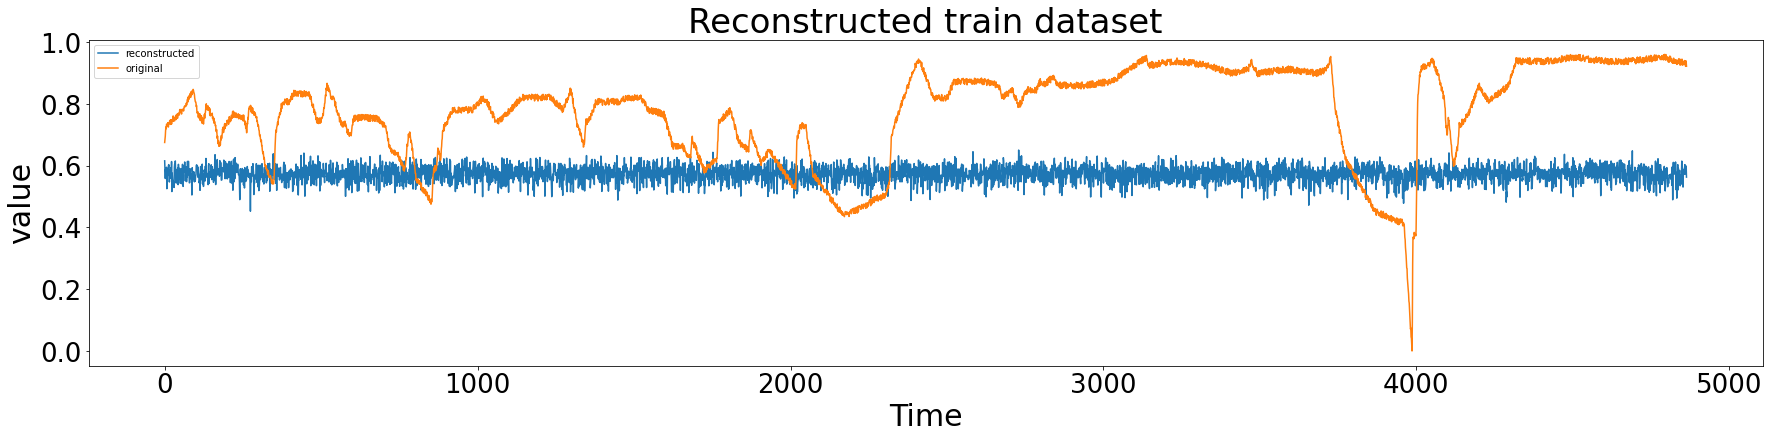

In [24]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values_train, reconstructed_train, label='reconstructed')
plt.plot(x_values_train, signal_train, label='original')


plt.title('Reconstructed train dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.legend()
    
plt.show()

In [25]:
x_values_test = np.arange(start=0, stop=len(reconstructed_test), step=1)
signal_test = temperature_data['signal'][5000:5000+len(reconstructed_test)]

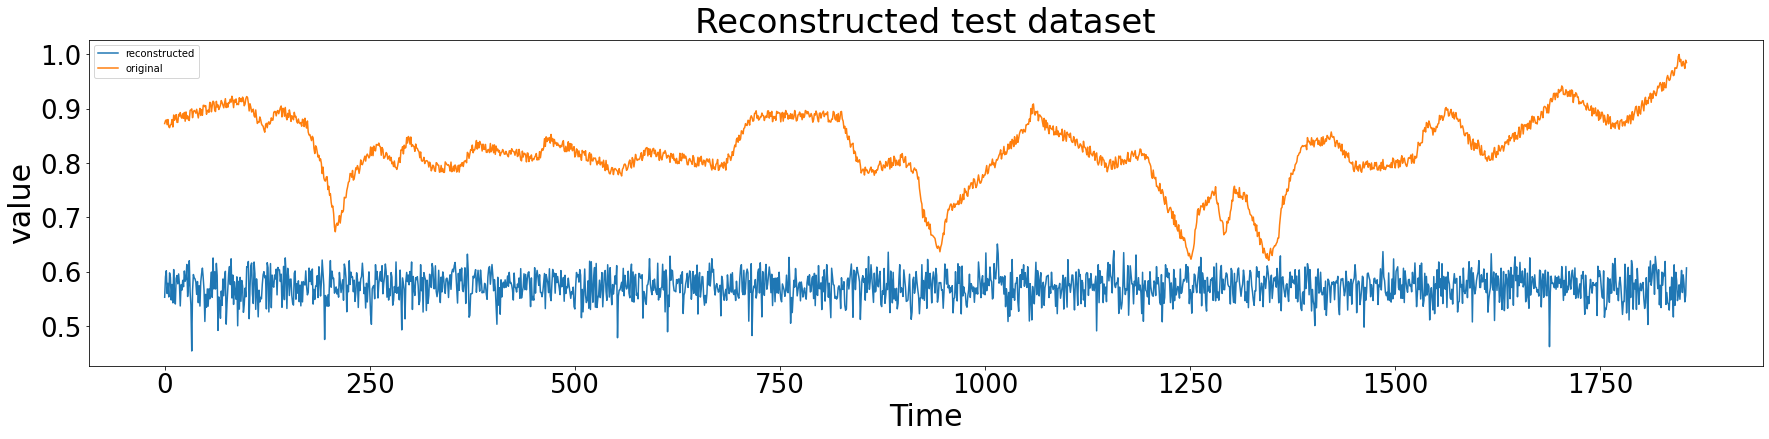

In [26]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values_test, reconstructed_test, label='reconstructed')
plt.plot(x_values_test, signal_test, label='original')


plt.title('Reconstructed test dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.legend()
    
plt.show()

Save reconstructed signal to file

In [27]:
df_train = pd.DataFrame (reconstructed_train, columns = ['reconstructed'])
df_train['timestamp'] = temperature_data_train['timestamp'][:len(reconstructed_train)].values
df_train['signal'] = temperature_data_train['signal'][:len(reconstructed_train)].values
print(df_train.head())
print(df_train.info())
df_train.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train_transformer_reconstructed.csv', index=False)


   reconstructed   timestamp    signal
0       0.615941  1386018900  0.675424
1       0.584978  1386019200  0.684525
2       0.558724  1386019500  0.695691
3       0.588130  1386019800  0.714638
4       0.566211  1386020100  0.725812
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  4864 non-null   float64
 1   timestamp      4864 non-null   int64  
 2   signal         4864 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 114.1 KB
None


In [28]:
print(len(reconstructed_test))

1856


In [29]:
df_test = pd.DataFrame (reconstructed_test, columns = ['reconstructed'])
print(df_test.info())
print(df_test.head())
df_test['timestamp'] = temperature_data_test['timestamp'][:len(reconstructed_test)].values
df_test['signal'] = temperature_data_test['signal'][:len(reconstructed_test)].values
print(df_test.head())
print(df_test.info())
df_test.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test_transformer_reconstructed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  1856 non-null   float64
dtypes: float64(1)
memory usage: 14.6 KB
None
   reconstructed
0       0.553039
1       0.590580
2       0.601887
3       0.559987
4       0.578781
   reconstructed   timestamp    signal
0       0.553039  1387518900  0.872812
1       0.590580  1387519200  0.878082
2       0.601887  1387519500  0.879614
3       0.559987  1387519800  0.870780
4       0.578781  1387520100  0.880160
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  1856 non-null   float64
 1   timestamp      1856 non-null   int64  
 2   signal         1856 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 43.6 KB
Non